# Применение алгоритмов машинного обучения без учителя для распознавания уровня модуляции QAM сигнала

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_pickle('/content/drive/MyDrive/Thesis/QAM_symbols_df.csv')

In [3]:
df

,M,SNR,Phase_shift,QAM_symbols
1,4,50,0,"[(0.7014392993075365-0.6989112769319755j), (0...."
2,4,50,0,"[(-0.7067526946873619-0.6995223913305271j), (0..."
3,4,50,0,"[(-0.6996921958171798+0.7009840192354847j), (-..."
4,4,50,3,"[(-0.7398838731040926+0.664625874417456j), (0...."
5,4,50,3,"[(0.739909895597325-0.6611057921027184j), (0.6..."
...,...,...,...,...
12086,1024,0,87,"[(0.18522224139101126+0.15108979133587475j), (..."
12087,1024,0,87,"[(-0.22127741229059017+0.07121604374153466j), ..."
12088,1024,0,90,"[(-0.40020864490078795-0.18589912117816118j), ..."
12089,1024,0,90,"[(-0.3619966950003602+0.04947952938787332j), (..."


# Использование метода KMeans

In [4]:
from sklearn.cluster import KMeans

In [ ]:
! pip install ModulationPy
import ModulationPy as mpy

# Создание фазового компенсатора

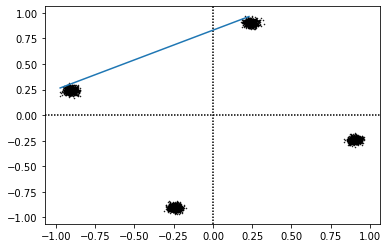

In [31]:
M = 4
SNR = 30
Ph = 30

test = df[(df.M == M) & 
          (df.SNR == SNR) & 
          (df.Phase_shift == Ph)] \
          .iloc[0].QAM_symbols
plt.scatter(test.real, 
            test.imag,
            c='black',
            marker='.',
            s=1)
plt.axhline(0, c='black', dashes=(1, 1))
plt.axvline(0, c='black', dashes=(1, 1))

quarter_1 = np.array([i for i in test if i.real >= 0 and i.imag >= 0])
quarter_2 = np.array([i for i in test if i.real <= 0 and i.imag >= 0])

# tops = [[np.mean(quarter_1.real), np.mean(quarter_1.imag)], 
#         [np.mean(quarter_2.real), np.mean(quarter_2.imag)]]

result = [np.where(abs(quarter_1) == np.amax(abs(quarter_1)))[0][0],
          np.where(abs(quarter_2) == np.amax(abs(quarter_2)))[0][0]]

result = [np.where(quarter_1[result[0]] == test)[0][0],
          np.where(quarter_2[result[1]] == test)[0][0]]

tops = [[test.real[result[0]],test.imag[result[0]]],
        [test.real[result[1]],test.imag[result[1]]]]

plt.plot(tops[1], tops[0])

## Вычисление угла поворота

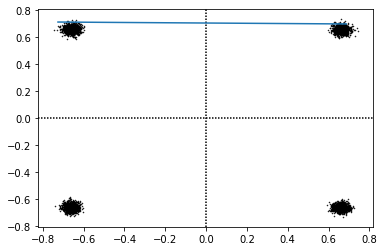

In [32]:
# BD=y2-y1;
# AD=x2-x1;
# C=arctg(BD/AD);

angle = np.arctan((tops[0][0] - tops[0][1])/(tops[1][0] - tops[1][1]))
test = test*np.exp(-angle*1j)
plt.scatter(test.real, 
            test.imag,
            c='black',
            marker='.',
            s=1)
plt.axhline(0, c='black', dashes=(1, 1))
plt.axvline(0, c='black', dashes=(1, 1))

quarter_1 = np.array([i for i in test if i.real >= 0 and i.imag >= 0])
quarter_2 = np.array([i for i in test if i.real <= 0 and i.imag >= 0])

result = [np.where(abs(quarter_1) == np.amax(abs(quarter_1)))[0][0],
          np.where(abs(quarter_2) == np.amax(abs(quarter_2)))[0][0]]

result = [np.where(quarter_1[result[0]] == test)[0][0],
          np.where(quarter_2[result[1]] == test)[0][0]]

tops = [[test.real[result[0]],test.imag[result[0]]],
        [test.real[result[1]],test.imag[result[1]]]]

plt.plot(tops[1], tops[0])

# Создание модели анлизатора уровня модуляции QAM сигнала, основанного на методе KMeans

In [15]:
from tqdm.notebook import tqdm # Установка прогресс бара
class QAMK():

  def __init__(self, phase=True):
    self.qam_clusters = {}
    self.phase = phase
    # Расчёт начальных кластеров для определенных видов модуляции
    for M in [4, 16, 64, 256, 1024]:
      modulator = mpy.QAMModem(M,
                              bin_input=False,
                              )
      consq = np.arange(M)
      QAM = modulator.modulate(consq)
      QAM = QAM/max(abs(QAM))
      self.qam_clusters[M] = np.concatenate((np.array(QAM.real).reshape(-1, 1), 
                                        np.array(QAM.imag).reshape(-1, 1)),
                                      axis=1)
      
  def angle_corrector(self, qam): # Фазовый компенсатор

    # Вычисление значений из 1-ой и 2-ой четверти
    quarter_1 = np.array([i for i in qam if i.real >= 0 and i.imag >= 0])
    quarter_2 = np.array([i for i in qam if i.real <= 0 and i.imag >= 0])

    # Поиск крайней верхней правой и левой точки
    result = [np.where(abs(quarter_1) == np.amax(abs(quarter_1)))[0][0],
              np.where(abs(quarter_2) == np.amax(abs(quarter_2)))[0][0]]

    result = [np.where(quarter_1[result[0]] == qam)[0][0],
              np.where(quarter_2[result[1]] == qam)[0][0]]
    # Вычисление координат крайней верхней правой и левой точки
    tops = [[qam.real[result[0]],qam.imag[result[0]]],
            [qam.real[result[1]],qam.imag[result[1]]]]

    # Подсчёт фазового набега
    return np.arctan((tops[0][0] - tops[0][1])/(tops[1][0] - tops[1][1]))

  def get_answers(self, qams):
    answers = [] # Создание массива для записи ответов
    for qam in qams: # Перебор всех QAM последовательностей

      if self.phase: # Если включен фазовый компенсатор, то компенсировать фазовый набег
            qam = qam*np.exp(-self.angle_corrector(qam)*1j)
            
      # Преобразование данных для метода KMeans
      X = pd.DataFrame({'real': qam.real, 'imag': qam.imag})
      # Списки для храненеия ошибок и кол-ва иттераций
      errors = []
      iters = []
      # Перебор кол-ва кластеров
      for i in [4, 16, 64, 256, 1024]:
        # Создание модели KMeans
        kmeans = KMeans(n_clusters = i, # Число кластеров
                        max_iter=12, # Максимальное число иттераций
                        random_state=42, # random seed
                        n_init=1, # Кол-во повторейний метода
                        n_jobs=-1, # Использование нес-их ядер
                        init=self.qam_clusters[i], # Нач-ое расп-ие кластеров
                        tol=1e-40)
        kmeans.fit(X) # Запуск модели на данных X

        errors.append(kmeans.inertia_) 
        iters.append(kmeans.n_iter_)

      # Результирующая таблица
      result = pd.DataFrame({'errors':errors, 'iters':iters}, index=[4, 16, 64, 256, 1024])

      result['maxerr'] = result.errors/result.errors.std() + 1
      result['er_it']  = result.maxerr * result.iters

      answers.append(result.er_it.idxmin())

    return answers

In [ ]:
answers = model.get_answers(np.array(df.QAM_symbols))

In [20]:
len(answers)

12090

In [21]:
df['Result'] = (df.M == answers)

In [22]:
df = df.drop("QAM_symbols")

,M,SNR,Phase_shift,QAM_symbols,Result
1,4,50,0,"[(0.7014392993075365-0.6989112769319755j), (0....",True
2,4,50,0,"[(-0.7067526946873619-0.6995223913305271j), (0...",True
3,4,50,0,"[(-0.6996921958171798+0.7009840192354847j), (-...",True
4,4,50,3,"[(-0.7398838731040926+0.664625874417456j), (0....",True
5,4,50,3,"[(0.739909895597325-0.6611057921027184j), (0.6...",True
...,...,...,...,...,...
12086,1024,0,87,"[(0.18522224139101126+0.15108979133587475j), (...",True
12087,1024,0,87,"[(-0.22127741229059017+0.07121604374153466j), ...",True
12088,1024,0,90,"[(-0.40020864490078795-0.18589912117816118j), ...",True
12089,1024,0,90,"[(-0.3619966950003602+0.04947952938787332j), (...",True


In [24]:
df1 = df.iloc[:]
df1.drop(["QAM_symbols", 'Phase_shift', 'SNR'], axis=1)\
.groupby(by=['M'], as_index=False).mean()

,M,Result
0,4,0.803143
1,16,0.720844
2,64,0.594706
3,256,0.460711
4,1024,0.986766


In [25]:
df1.Result.mean()

0.7132340777502068

In [26]:
df3 = df1.drop(["QAM_symbols", 'Phase_shift'], axis=1)
df3.SNR[(df.SNR >= 0) & (df.SNR < 15)] = '[0, 15)'
df3.SNR[(df.SNR >= 15) & (df.SNR < 30)] = '[15, 30)'
df3.SNR[(df.SNR >= 30) & (df.SNR <= 50)] = '[30, 50)'
df3.groupby(by=['M', 'SNR'], as_index=False).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,M,SNR,Result
0,4,"[0, 15)",0.360215
1,4,"[15, 30)",1.000000
2,4,"[30, 50)",1.000000
3,16,"[0, 15)",0.092742
4,16,"[15, 30)",1.000000
5,16,"[30, 50)",1.000000
6,64,"[0, 15)",0.000000
7,64,"[15, 30)",0.637481
8,64,"[30, 50)",1.000000
9,256,"[0, 15)",0.000000


In [29]:
df3 = df1.drop(["QAM_symbols", 'SNR'], axis=1)
df3.Phase_shift[(df.Phase_shift >= 0) & (df.Phase_shift < 30)] = '[0, 30)'
df3.Phase_shift[(df.Phase_shift >= 30) & (df.Phase_shift < 60)] = '[30, 60)'
df3.Phase_shift[(df.Phase_shift >= 60) & (df.Phase_shift <= 90)] = '[60, 90)'
df3.groupby(by=['M', 'Phase_shift'], as_index=False).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,M,Phase_shift,Result
0,4,"[0, 30)",0.803846
1,4,"[30, 60)",0.808974
2,4,"[60, 90)",0.797203
3,16,"[0, 30)",0.715385
4,16,"[30, 60)",0.725641
5,16,"[60, 90)",0.721445
6,64,"[0, 30)",0.600000
7,64,"[30, 60)",0.591026
8,64,"[60, 90)",0.593240
9,256,"[0, 30)",0.458974


Text(0, 0.5, 'Точность')

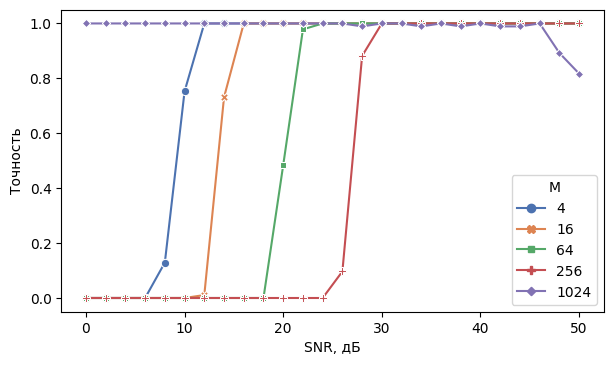

In [30]:
df4 = df1.drop(["QAM_symbols", 'Phase_shift'], axis=1)\
.groupby(by=['M', 'SNR'], as_index=False).mean()
plt.figure(figsize=(7,4), dpi=100)
sns.lineplot(x='SNR', y='Result', data=df4, hue='M',
             style='M', markers=True, dashes=False,
             palette='deep')
plt.xlabel('SNR, дБ')
plt.ylabel('Точность')